<a href="https://colab.research.google.com/github/SYEDFAIZAN1987/3D-Liver-and-Liver-Tumor-Segmentation/blob/main/3D_Liver_and_Liver_Tumor_segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from celluloid import Camera
from IPython.display import HTML

In [ ]:
root = Path("/content/Task03_Liver_rs/imagesTr/")
label = Path("/content/Task03_Liver_rs/labelsTr/")

In [ ]:
def change_img_to_label_path(path):
    """
    Replaces imagesTr with labelsTr
    """
    parts = list(path.parts)  # get all directories within the path
    parts[parts.index("imagesTr")] = "labelsTr"  # Replace imagesTr with labelsTr
    return Path(*parts)  # Combine list back into a Path object


In [ ]:
sample_path = list(root.glob("liver*"))[0]  # Choose a subject
sample_path_label = change_img_to_label_path(sample_path)

In [ ]:
data = nib.load(sample_path)
label = nib.load(sample_path_label)

ct = data.get_fdata()
mask = label.get_fdata().astype(int)  # Class labels should not be handled as float64

In [ ]:
nib.aff2axcodes(data.affine)

('R', 'A', 'S')

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(ct.shape[2]):  # Axial view
    plt.imshow(ct[:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(mask[:,:,i]==0, mask[:,:,i])
    plt.imshow(mask_, alpha=0.5)
    # plt.axis("off")
    camera.snap()  # Store the current slice
plt.tight_layout()
animation = camera.animate()  # Create the animation




<IPython.core.display.Javascript object>

In [ ]:
HTML(animation.to_html5_video())

Model

In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Dataset class
class LiverTumorDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted(os.listdir(image_dir))
        self.label_files = sorted(os.listdir(label_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])

        image = nib.load(img_path).get_fdata()
        label = nib.load(label_path).get_fdata()

        # Normalize and resize to (128, 128, 128)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long).unsqueeze(0)

        image = nn.functional.interpolate(image.unsqueeze(0), size=(128, 128, 128), mode='trilinear', align_corners=False).squeeze(0)
        label = nn.functional.interpolate(label.unsqueeze(0).float(), size=(128, 128, 128), mode='nearest').squeeze(0).long()

        return image, label

# UNet Model
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = nn.Sequential(nn.Conv3d(1, 32, 3, padding=1), nn.ReLU(), nn.Conv3d(32, 32, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = nn.Sequential(nn.Conv3d(32, 64, 3, padding=1), nn.ReLU(), nn.Conv3d(64, 64, 3, padding=1), nn.ReLU())
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = nn.Sequential(nn.Conv3d(64, 128, 3, padding=1), nn.ReLU(), nn.Conv3d(128, 128, 3, padding=1), nn.ReLU())

        self.upconv2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(nn.Conv3d(128, 64, 3, padding=1), nn.ReLU(), nn.Conv3d(64, 64, 3, padding=1), nn.ReLU())
        self.upconv1 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec1 = nn.Sequential(nn.Conv3d(64, 32, 3, padding=1), nn.ReLU(), nn.Conv3d(32, 32, 3, padding=1), nn.ReLU())

        self.output = nn.Conv3d(32, 3, 1)  # Background, Liver, Tumor

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.upconv2(bottleneck)
        dec2 = self.dec2(torch.cat((dec2, enc2), dim=1))
        dec1 = self.upconv1(dec2)
        dec1 = self.dec1(torch.cat((dec1, enc1), dim=1))

        return self.output(dec1)

# Training & Validation Functions
def train(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze(1))  # Squeeze channel dim
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.squeeze(1))
            running_loss += loss.item()
    return running_loss / len(loader)

# Main Training Loop
image_dir = "/content/Task03_Liver_rs/imagesTr"
label_dir = "/content/Task03_Liver_rs/labelsTr"

dataset = LiverTumorDataset(image_dir, label_dir)
train_loader = DataLoader(dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 5
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    val_loss = validate(model, val_loader, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')


Epoch 1/5, Train Loss: 0.5494, Val Loss: 0.1504
Epoch 2/5, Train Loss: 0.1222, Val Loss: 0.1121
Epoch 3/5, Train Loss: 0.1111, Val Loss: 0.1103
Epoch 4/5, Train Loss: 0.1015, Val Loss: 0.0989
Epoch 5/5, Train Loss: 0.0956, Val Loss: 0.0895


Testing and Evaluation

In [50]:
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import HTML
import torch
import numpy as np

# Function to create overlapping patches
def extract_patches(volume, patch_size=(96, 96, 96), stride=(8, 8, 8)):
    patches = []
    indices = []
    D, H, W = volume.shape[-3:]

    for z in range(0, D, stride[0]):
        for y in range(0, H, stride[1]):
            for x in range(0, W, stride[2]):
                patch = volume[:, z:min(z+patch_size[0], D),
                               y:min(y+patch_size[1], H),
                               x:min(x+patch_size[2], W)]
                patches.append(patch)
                indices.append((z, y, x))
    return patches, indices

# Function to aggregate patches into a full volume
def aggregate_patches(patches, indices, volume_shape, patch_size=(96, 96, 96)):
    num_classes = patches[0].shape[0]  # Assuming output shape: [num_classes, D, H, W]

    aggregated_volume = torch.zeros((num_classes, *volume_shape[-3:]), device=patches[0].device)
    count_volume = torch.zeros_like(aggregated_volume)

    for patch, (z, y, x) in zip(patches, indices):
        dz = min(patch.shape[1], volume_shape[-3] - z)
        dy = min(patch.shape[2], volume_shape[-2] - y)
        dx = min(patch.shape[3], volume_shape[-1] - x)

        # Aggregating with boundary checks
        aggregated_volume[:, z:z+dz, y:y+dy, x:x+dx] += patch[:, :dz, :dy, :dx]
        count_volume[:, z:z+dz, y:y+dy, x:x+dx] += 1

    return aggregated_volume / count_volume.clamp(min=1)

# Evaluation for one of the validation samples
IDX = 4
image, mask = dataset[IDX]
image, mask = image.to(device), mask.to(device)

# Extract patches
patches, indices = extract_patches(image)

# Predict on patches
predictions = []
with torch.no_grad():
    for patch in patches:
        patch = patch.unsqueeze(0).to(device)  # Add batch dimension -> Shape: [1, 1, D, H, W]
        pred = model(patch)                    # Output: [1, num_classes, D, H, W]
        predictions.append(pred.squeeze(0))   # Remove batch dimension

# Aggregate predictions back to full volume
output_tensor = aggregate_patches(predictions, indices, image.shape)

# Visualization
fig = plt.figure()
camera = Camera(fig)
pred = output_tensor.argmax(0).cpu()  # Class with highest probability

for i in range(0, output_tensor.shape[2], 2):  # Axial slices
    plt.imshow(image[0, :, :, i].cpu(), cmap="bone")
    pred_mask = np.ma.masked_where(pred[:, :, i] == 0, pred[:, :, i])
    label_mask = np.ma.masked_where(mask[0, :, :, i].cpu() == 0, mask[0, :, :, i].cpu())

    plt.imshow(pred_mask, alpha=0.3, cmap="autumn")
    plt.imshow(label_mask, alpha=0.5, cmap="jet")  # Ground truth

    camera.snap()

animation = camera.animate(interval=200)



<IPython.core.display.Javascript object>

In [49]:
HTML(animation.to_html5_video())

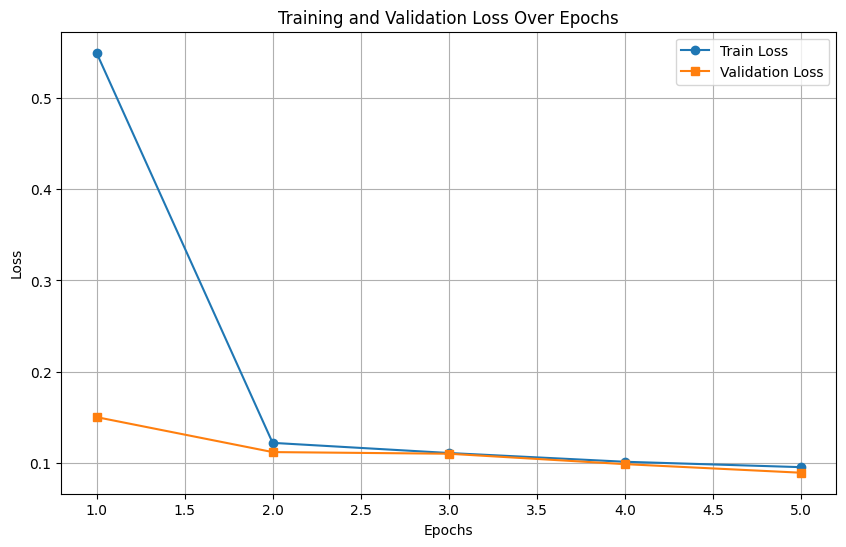

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
# Provided loss values
train_losses = [0.5494, 0.1222, 0.1111, 0.1015, 0.0956]
val_losses = [0.1504, 0.1121, 0.1103, 0.0989, 0.0895]
epochs = range(1, 6)

# Plotting Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='s', label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)

# Ensure animation is displayed before plt.show()
# (If you have an animation, display it using animation.to_html5_video() or animation.save() before plt.show())
# For example:
# from IPython.display import HTML
# HTML(animation.to_html5_video())  # Assuming 'animation' is your Camera.animate() object

plt.show()  # Display the loss curves